<a href="https://colab.research.google.com/github/breno-gabriel/Intrusion-Detection-/blob/main/Copy_of_Aula_Pr%C3%A1tica_2_One_Class_Novelty_%5BN%C3%A3o_Resolvido%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import OneClassSVM

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
sns.set_theme()

In [ ]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)

# Download CIC IDS 2017

[Este](https://www.unb.ca/cic/datasets/ids-2017.html) conjunto de dados contém informações sobre fluxos de rede, representando tanto o tráfego benigno quanto ataques populares. Para o ambiente de teste desta coleta de dados, uma rede foi configurada para o atacante e uma rede separada foi configurada para as vítimas, esta última contendo firewalls, roteadores, switches, servidores e estações de trabalho em execução em diferentes versões dos sistemas operacionais Windows e Linux. Para gerar o tráfego benigno, os autores utilizaram um sistema desenvolvido por eles mesmos, que então extraiu o comportamento abstrato de 25 usuários com base em diferentes protocolos de aplicação. Os dados foram coletados ao longo de cinco dias de atividade de rede e foram processados para extrair mais de 80 features do conjunto de dados usando a ferramenta CICFlowMeter8.


In [ ]:
# Baixando dataset CIC IDS 2017 mais rápido através de código de arquivo do Google Drive
!gdown '1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD' -O CIC_IDS_2017.zip

Downloading...
From: https://drive.google.com/uc?id=1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD
To: /content/CIC_IDS_2017.zip
100% 235M/235M [00:06<00:00, 34.0MB/s]


In [ ]:
!unzip CIC_IDS_2017.zip

Archive:  CIC_IDS_2017.zip
   creating: MachineLearningCVE/
  inflating: MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  


# Carregando os dados

In [ ]:
df_list = []
for file in os.listdir('MachineLearningCVE/'):
  df_aux = pd.read_csv(f'MachineLearningCVE/{file}')
  df_list.append(df_aux)
df = pd.concat(df_list, ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [ ]:
list(df.columns)[:6]

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets']

Algumas colunas tem seus nomes iniciados com espaços ou finalizados com espaços. Vamos remover esses espaços não úteis para ajustar o nome das colunas.

In [ ]:
def remove_initial_and_ending_spaces(name):
    regex = r'^(?:\s+)?(?P<gp>.+?)(?:\s+)?$'
    mo = re.search(regex, name)
    if mo is not None:
      return mo['gp']
    else:
      print(f'Deu erro em: {name}')
      return name

In [ ]:
for col in df.columns:
    df = df.rename({col:remove_initial_and_ending_spaces(col)}, axis='columns')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Limpando os dados

É necessário limpar os dados realizando:
- Descarte de registros duplicados
- Descarte de registros com valores NaN (Not a Number)/ Null / NA (Not Available)
- Evitar registros com valores não finitos. Nesse caso, uma abordagem válida é substituirmos os mesmos pelo maior valor finito presente no dataset.

Registros duplicados

In [ ]:
df[df.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
277,53,142,2,2,70,102,35,35,35.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
824,80,78,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1251,80,143,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1363,443,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1405,443,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830701,53,179,2,2,46,46,23,23,23.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830725,53,161,2,2,82,114,41,41,41.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830726,53,212,2,2,84,162,42,42,42.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830731,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Descartando duplicadas
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 2830743, tamanho final 2522362 | Descartadas 308381 duplicadas


Registros com valores Null/NaN/NA

In [ ]:
df.columns[df.isna().any(axis=0)]

Index(['Flow Bytes/s'], dtype='object')

In [ ]:
df[df.isna().any(axis=1)][['Flow Bytes/s']]

,Flow Bytes/s
18639,NaN
54760,NaN
74624,NaN
91230,NaN
93282,NaN
...,...
2740049,NaN
2767532,NaN
2791593,NaN
2809052,NaN


In [ ]:
# Descartando registros com valores NaN/Null/NA
initial_len = df.shape[0]
df = df.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartados {initial_len - df.shape[0]} registros com valores NA')

Tamanho inicial: 2522362, tamanho final 2522009 | Descartados 353 registros com valores NA


In [ ]:
df = df.reset_index(drop=True)

Registros com valores não finitos

In [ ]:
df_columns_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=0)
df_columns_isfinite[df_columns_isfinite == False]

Flow Bytes/s      False
Flow Packets/s    False
dtype: bool

In [ ]:
df_rows_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=1)
inf_indexes = df_rows_isfinite[df_rows_isfinite == False].index
df.iloc[inf_indexes][['Flow Bytes/s', 'Flow Packets/s', 'Flow Duration']]

,Flow Bytes/s,Flow Packets/s,Flow Duration
5617,inf,inf,0
6111,inf,inf,0
7246,inf,inf,0
8700,inf,inf,0
15895,inf,inf,0
...,...,...,...
2515309,inf,inf,0
2515565,inf,inf,0
2516784,inf,inf,0
2516908,inf,inf,0


In [ ]:
# Evitando registros com valores não finitos
max_finite_flow_packets_per_sec = df[np.isfinite(df['Flow Packets/s'])]['Flow Packets/s'].max()
max_finite_flow_bytes_per_sec = df[np.isfinite(df['Flow Bytes/s'])]['Flow Bytes/s'].max()

df.loc[df['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = max_finite_flow_packets_per_sec
df.loc[df['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = max_finite_flow_bytes_per_sec

# Mini análise exploratória

### Quantidade de instâncias benignas x maliciosas

<Axes: xlabel='Label', ylabel='count'>

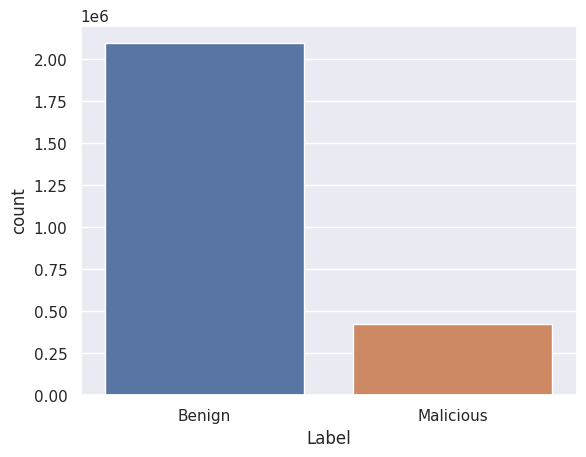

In [ ]:
sns.countplot(data=df['Label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='Label')

**Dados não balanceados**. Impactos:
- Dificuldade de treinar modelos supervisionados
- Dificuldade de avaliar resultados com métricas tradicionais como acurácia

### Quantidade de instâncias por tipo de ataque

Abaixo está um descritivo para os ataques do dataset:

**DoS (Denial of Service)**: Esses ataques, como "DoS Hulk", "DoS GoldenEye", "DoS Slowloris", "DoS Slowhttptest" e "DDoS" visam tornar temporariamente uma máquina ou recurso de rede indisponível, sendo diferenciados pelo protocolo e estratégia usados para causar a negação de serviço. No caso do "DDoS", várias máquinas Windows 8.1 foram usadas para enviar solicitações UDP, TCP e HTTP.

**FTP Patator" e "SSH Patator**: Usam o software Patator para adivinhar senhas por força bruta com o uso de listas de palavras.

**Web - Brute Force**: Usa força bruta em uma aplicação com listas de palavras.

**Web - Injeção de SQL**: Esse ataque explora vulnerabilidades em máquinas conectadas publicamente à Internet usando injeção SQL.

**Web - XSS (Cross-Site Scripting)**: Representa injeções de scripts em aplicativos da web, visando a execução de ações maliciosas por outros usuários do aplicativo.

**PortScan**: Realizados com a ferramenta NMap, esses ataques buscam informações sobre os serviços e portas abertas em um alvo.

**Bot**: Esse ataque tem várias possibilidades, como roubo de dados, envio de spam e acesso ao dispositivo. .

**Infiltration**: Baseado na infecção de uma máquina após um usuário abrir um arquivo malicioso.

In [ ]:
df['Label'] = df['Label'].replace({'Web Attack � Brute Force':'Brute Force', 'Web Attack � XSS':'XSS', 'Web Attack � Sql Injection':'Sql Injection'})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'DoS Hulk'),
  Text(1, 0, 'DDoS'),
  Text(2, 0, 'PortScan'),
  Text(3, 0, 'DoS GoldenEye'),
  Text(4, 0, 'FTP-Patator'),
  Text(5, 0, 'DoS slowloris'),
  Text(6, 0, 'DoS Slowhttptest'),
  Text(7, 0, 'SSH-Patator'),
  Text(8, 0, 'Bot'),
  Text(9, 0, 'Brute Force'),
  Text(10, 0, 'XSS'),
  Text(11, 0, 'Infiltration'),
  Text(12, 0, 'Sql Injection'),
  Text(13, 0, 'Heartbleed')])

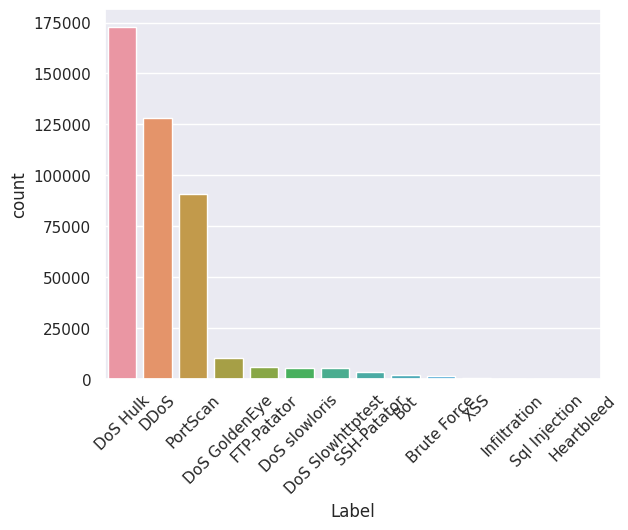

In [ ]:
sns.countplot(data=df.query('Label != "BENIGN"')[['Label']], x='Label', order = df.query('Label != "BENIGN"')['Label'].value_counts().index)
plt.xticks(rotation=45)

Ataques menos representados

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Infiltration'),
  Text(1, 0, 'Brute Force'),
  Text(2, 0, 'XSS'),
  Text(3, 0, 'Sql Injection'),
  Text(4, 0, 'Heartbleed')])

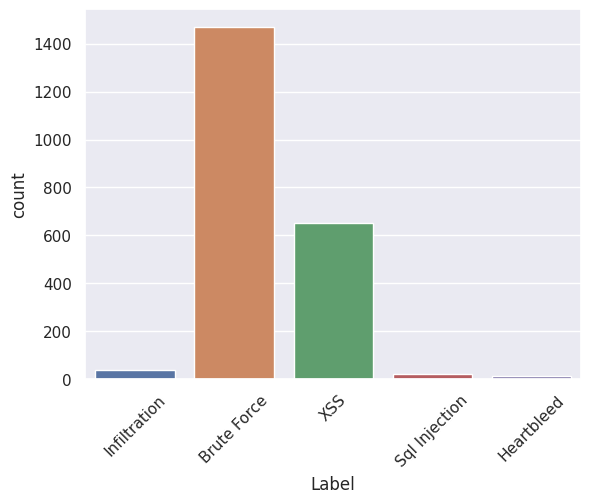

In [ ]:
N_LESS_REPRESENTED_LABELS = 5

sns.countplot(data=df[df['Label'].isin(df.groupby('Label').size().sort_values(ascending=False)[(-1)*N_LESS_REPRESENTED_LABELS:].index)], x='Label')
plt.xticks(rotation=45)

### Estatísticas dos dados

In [ ]:
interesting_cols = ['Flow Duration', 'Flow Bytes/s', 'Total Fwd Packets', 'Average Packet Size', 'SYN Flag Count']
df[interesting_cols].describe()

,Flow Duration,Flow Bytes/s,Total Fwd Packets,Average Packet Size,SYN Flag Count
count,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06
mean,1.658364e+07,2.404467e+06,1.027750e+01,2.123412e+02,4.874487e-02
std,3.522618e+07,5.254864e+07,7.942294e+02,3.454504e+02,2.153342e-01
min,-1.300000e+01,-2.610000e+08,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.080000e+02,1.194510e+02,2.000000e+00,9.000000e+00,0.000000e+00
50%,5.058700e+04,3.722028e+03,2.000000e+00,8.075000e+01,0.000000e+00
75%,5.330376e+06,1.079162e+05,6.000000e+00,1.796923e+02,0.000000e+00
max,1.200000e+08,2.071000e+09,2.197590e+05,3.893333e+03,1.000000e+00


# Dividindo dados nos conjuntos de treino, validação e teste

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos de clustering vão ser capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Porém, devem ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

In [ ]:
df_train = df.query('Label == "BENIGN"').sample(frac=0.60, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

X_train = df_train.drop('Label', axis='columns')

In [ ]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('Label', axis='columns'), df_val_test['Label'], test_size=0.65, stratify=df_val_test['Label'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [ ]:
del df_train, df_val_test

# Analisando correlação entre features

**Por que remover features?**

Vamos descartar features com alta correlação evitando passar informações redundantes ao modelo. Dessa forma, conseguiremos obter um modelo mais simples e com menor custo computacional.

In [ ]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [ ]:
corr_matrix = X_train.corr().abs()
correlation_list = get_highly_correlated_features(corr_matrix, 0.95)

In [ ]:
correlation_list[:10]

[(('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 1.0000000000000007),
 (('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.9999998712148583),
 (('Total Backward Packets', 'Total Fwd Packets'), 0.9994222955750526)]

In [ ]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

In [ ]:
f2drop

['Bwd Packet Length Mean',
 'Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Length of Fwd Packets',
 'Total Backward Packets',
 'Total Length of Bwd Packets',
 'Subflow Fwd Packets',
 'RST Flag Count',
 'Subflow Bwd Packets',
 'Flow Duration',
 'Packet Length Mean',
 'Flow IAT Max',
 'Idle Mean',
 'Fwd IAT Total',
 'Max Packet Length',
 'Fwd Packet Length Max',
 'Bwd IAT Max',
 'Bwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Idle Max']

A feature "Destination Port", também não fornece muita contribuição devido que a mesma está codificada com valores inteiros, indicando uma relação de grandeza, como 44720 > 80, que não apresenta sentido semântico quando se trata da porta de destino de um fluxo de rede.

In [ ]:
f2drop = f2drop + ['Destination Port']

In [ ]:
X_train = X_train.drop(f2drop, axis='columns')
X_val = X_val.drop(f2drop, axis='columns')
X_test = X_test.drop(f2drop, axis='columns')

# Detecção de Anomalias com o Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

N_ESTIMATORS = 100

model_iforest = IsolationForest(n_estimators = N_ESTIMATORS, random_state=RANDOM_SEED).fit(X_train)

## Definindo um threshold e avaliando resultados

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'recall': recall,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

## Conjunto de validação

In [ ]:
val_scores_iforest = model_iforest.score_samples(X_val)

In [ ]:
val_scores_iforest = np.abs(val_scores_iforest)

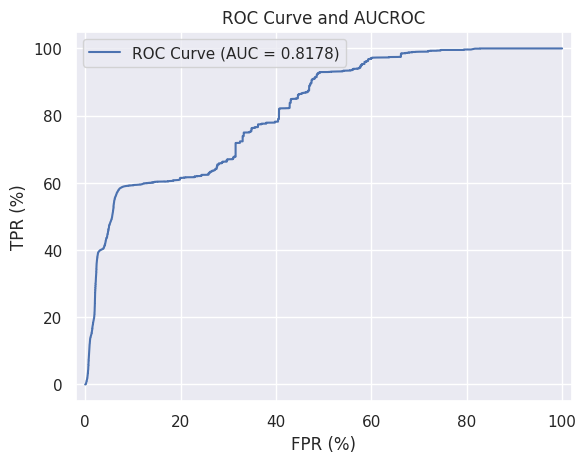

In [ ]:
plot_roc_curve(y_val, val_scores_iforest)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_scores_iforest)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
20193,0.073230,0.584056,0.476341,0.510826
20195,0.073247,0.584069,0.476313,0.510822
20197,0.073271,0.584076,0.476289,0.510805
20198,0.073278,0.584076,0.476282,0.510798
20187,0.073206,0.583995,0.476380,0.510789
...,...,...,...,...
44,0.000869,0.000047,0.677725,-0.000822
47,0.000889,0.000067,0.677182,-0.000822
41,0.000855,0.000027,0.678095,-0.000828
48,0.000900,0.000067,0.677178,-0.000833


In [ ]:
BEST_IFOREST_VALIDATION_THRESHOLD = 0.451924

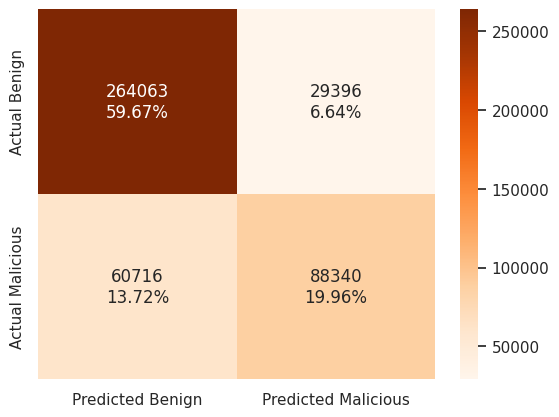

In [ ]:
plot_confusion_matrix(y_val, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'acc': 0.7963639650633312,
 'tpr': 0.5926631601545728,
 'fpr': 0.10017072231555345,
 'precision': 0.7503227559964667,
 'f1-score': 0.6622387477885393}

In [ ]:
get_tpr_per_attack(classes_val, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.89896852684475,
 'DDoS': 0.6353613355354194,
 'PortScan': 0.007613175197407745,
 'DoS GoldenEye': 0.6780555555555555,
 'FTP-Patator': 0.0004816955684007707,
 'DoS slowloris': 0.6042440318302388,
 'DoS Slowhttptest': 0.8765027322404372,
 'SSH-Patator': 0.0,
 'Bot': 0.02342606149341142,
 'Brute Force': 0.04669260700389105,
 'XSS': 0.02631578947368421,
 'Infiltration': 0.7692307692307693,
 'Sql Injection': 0.14285714285714285,
 'Heartbleed': 1.0}

### Usando a predição direta do modelo

1.   List item
2.   List item



In [ ]:
val_preds_iforest = model_iforest.predict(X_val)

In [ ]:
val_preds_iforest[val_preds_iforest == 1] = 0
val_preds_iforest[val_preds_iforest == -1] = 1

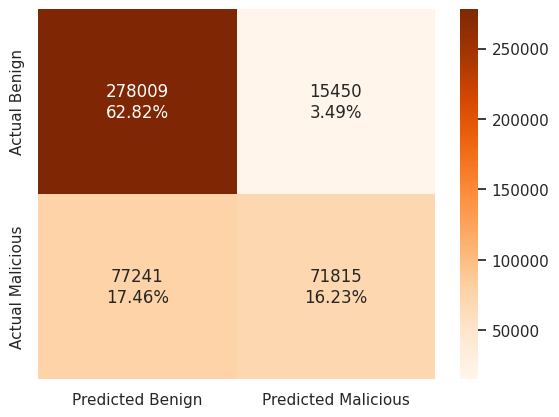

In [ ]:
plot_confusion_matrix(y_val, val_preds_iforest)

In [ ]:
get_overall_metrics(y_val, val_preds_iforest)

{'acc': 0.7905359140368123,
 'tpr': 0.4817987870330614,
 'fpr': 0.05264789970660297,
 'precision': 0.8229530739700911,
 'f1-score': 0.6077750178782249}

In [ ]:
get_tpr_per_attack(classes_val, val_preds_iforest)

{'DoS Hulk': 0.8612635546151811,
 'DDoS': 0.3646163460250859,
 'PortScan': 0.0015415106804668576,
 'DoS GoldenEye': 0.20666666666666667,
 'FTP-Patator': 0.0,
 'DoS slowloris': 0.5612732095490717,
 'DoS Slowhttptest': 0.8021857923497268,
 'SSH-Patator': 0.0,
 'Bot': 0.02342606149341142,
 'Brute Force': 0.042801556420233464,
 'XSS': 0.021929824561403508,
 'Infiltration': 0.6923076923076923,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

## Conjunto de teste

In [ ]:
test_scores_iforest = model_iforest.score_samples(X_test)

In [ ]:
test_scores_iforest = np.abs(test_scores_iforest)

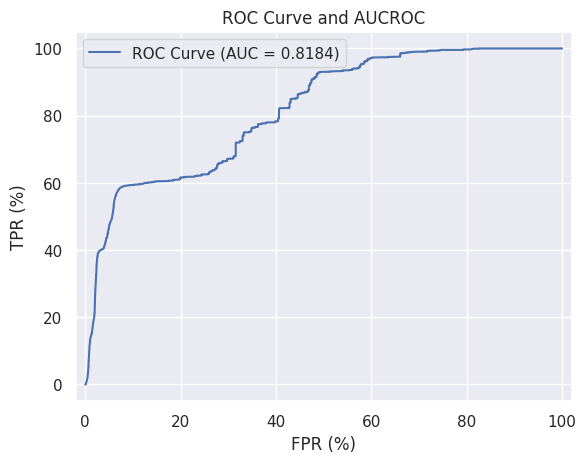

In [ ]:
plot_roc_curve(y_test, test_scores_iforest)

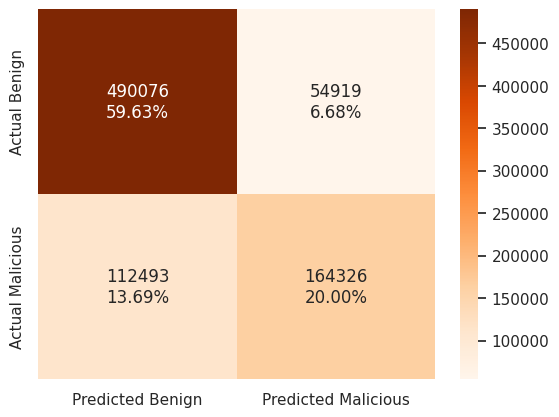

In [ ]:
plot_confusion_matrix(y_test, test_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test, test_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'acc': 0.796289671385496,
 'tpr': 0.5936225475852452,
 'fpr': 0.10076973183240213,
 'precision': 0.7495085406736756,
 'f1-score': 0.6625193523416334}

In [ ]:
get_tpr_per_attack(classes_test, test_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.9015309301290609,
 'DDoS': 0.63612546568922,
 'PortScan': 0.007284184848895515,
 'DoS GoldenEye': 0.6761890517499252,
 'FTP-Patator': 0.00077780658542909,
 'DoS slowloris': 0.5914285714285714,
 'DoS Slowhttptest': 0.8708063566804002,
 'SSH-Patator': 0.0,
 'Bot': 0.024409448818897637,
 'Brute Force': 0.05439330543933055,
 'XSS': 0.0330188679245283,
 'Infiltration': 0.8695652173913043,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

# Normalizando os dados

In [ ]:
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)

norm_X_train = std_scaler.transform(X_train)
norm_X_val = std_scaler.transform(X_val)
norm_X_test = std_scaler.transform(X_test)

In [ ]:
#del X_train, X_val, X_test

In [ ]:
random_val_indexes = np.random.choice(norm_X_val.shape[0], int(norm_X_val.shape[0]*0.02), replace=False)
norm_X_val_subset = norm_X_val[random_val_indexes,:]
y_val_subset = y_val[random_val_indexes]
classes_val_subset = classes_val[random_val_indexes]

In [ ]:
random_train_indexes = np.random.choice(norm_X_train.shape[0], int(norm_X_train.shape[0]*0.02), replace=False)
norm_X_train_subset = norm_X_train[random_train_indexes,:]

In [ ]:
random_test_indexes = np.random.choice(norm_X_test.shape[0], int(norm_X_test.shape[0]*0.02), replace=False)
norm_X_test_subset = norm_X_test[random_test_indexes,:]
y_test_subset = y_test[random_test_indexes]
classes_test_subset = classes_test[random_val_indexes]

# One Class SVM Novelty

  O algoritmo de one Class SVM Novelty é um algoritmo de aprendizado de maquina não supervisionado utilizado para a detecção de anomalias. Em seu treinamento, é utilizado apenas uma classe específica. Após treinada, o algoritmo passa a detectar instâncias que não pertencem a essas classes (anômalias ou "outlier"). Essa abordagem é útil para quando não temos exemplos o suficiente para as anômalias.

#Conjunto de validação#

A segunte célula é responsável pela tunagem de hiperparâmetro. A forma escolhida foi através de duas estruturas de laço aninhadas, as quais testam um total de 12 possibilidades de hiperparâmetros 'nu' e 'gamma'. Escolherei o maior recall, pois o mesmo apresentou um melhor resultado para a matriz de confusão.

In [ ]:
gamma_values = [0.001, 0.01, 0.1, 1]
nu_values = [0.01, 0.1, 0.5]

precision_values = []

recall_values = []

gamma_value = []

nu_value = []

for gamma in gamma_values:
  for nu in nu_values:

    one_class =  OneClassSVM(kernel='rbf', gamma= gamma, nu = nu).fit(norm_X_train_subset)

    val_predict_one_class = one_class.predict(norm_X_val_subset)

    val_predict_one_class[val_predict_one_class == 1] = 0
    val_predict_one_class[val_predict_one_class == -1] = 1

    tn, fp, fn, tp = confusion_matrix(y_val_subset, val_predict_one_class).ravel()

    precision = tp/(tp+fp)

    recall = tp/(tp+fn)

    precision_values.append(precision)

    recall_values.append(recall)

    gamma_value.append(gamma)

    nu_value.append(nu)

In [ ]:
gamma_value

[0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1, 1]

In [ ]:
nu_value

[0.01, 0.1, 0.5, 0.01, 0.1, 0.5, 0.01, 0.1, 0.5, 0.01, 0.1, 0.5]

In [ ]:
print(recall_values)

[0.2605896306336835, 0.6079295154185022, 0.6431718061674009, 0.5435445611657065, 0.6048797017960014, 0.6452050152490681, 0.5862419518807184, 0.6052185699762792, 0.8759742460182989, 0.8021009827177228, 0.7939681463910538, 0.9308708912233141]


In [ ]:
print(precision_values)

[0.9540942928039702, 0.7550505050505051, 0.3906153529532826, 0.968014484007242, 0.7563559322033898, 0.390403936846422, 0.8768373035985808, 0.7622705932565087, 0.4689767779390421, 0.703835860838537, 0.7104305639781686, 0.4807490374518726]


O seguinte modelo foi treinado sem os hiperparâmetros otimizados.

---



---



In [ ]:
svm = OneClassSVM(kernel='rbf', gamma= "auto", nu=0.03).fit(norm_X_train_subset)

In [ ]:
val_scores_one_class = svm.score_samples(norm_X_val_subset)

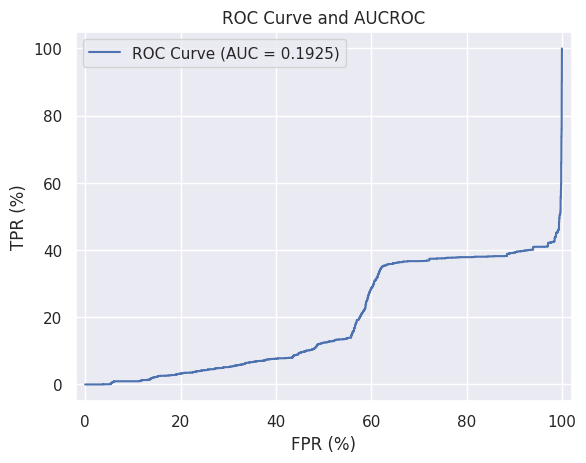

In [ ]:
plot_roc_curve(y_val_subset, val_scores_one_class)

In [ ]:
val_predict_one_class = svm.predict(norm_X_val_subset)

In [ ]:
val_predict_one_class[val_predict_one_class == 1] = 0
val_predict_one_class[val_predict_one_class == -1] = 1

A seguinte célula é responsável pela matriz de confusão. Percebemos que a quantidade de verdadeiros positivos é grande, enquanto a quatidade de verdadeiros negativos é razoalvel. A quantidade de Falsos negativos é pequena, porém a quantidade de Falsos positivos é consideravel. Seria interessante reduzir a quantidade de falsos positivos, pois não é interessante que o modelo afirme que um dados maligno seja rotulado como benigno. Nessa situação, os falsos positivos são mais prejudiciais que os falsos negativos.

---



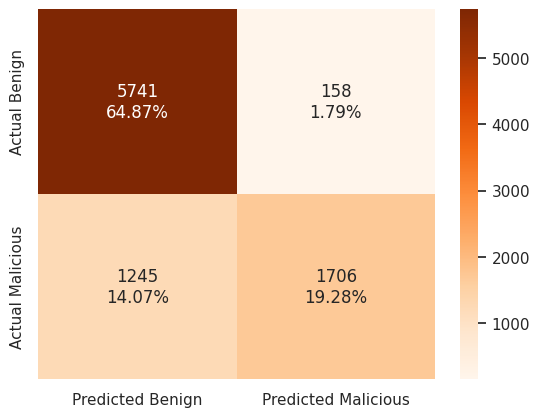

In [ ]:
plot_confusion_matrix(y_val_subset, val_predict_one_class)

A célula seguinte trabalha com as métricas gerais do modelo (acurácia, taxa de verdadeiro positivo, taxa de falso positivo , precisão e f1 - score). Perceba que a acurácia do modelo é alta, o que pode ser enganosa em base de dados classes desbalanceadas. percebemos que temos uma taxa de verdadeiros positivos mediana e uma taxa de falsos negativos baixa. A precisão está ótima, ou seja, de todos os dados que o modelo considera como positivo, uma boa quantidade de fato é positiva.

In [ ]:
get_overall_metrics(y_val_subset, val_predict_one_class)

{'acc': 0.8414689265536723,
 'tpr': 0.5781091155540494,
 'fpr': 0.026784200711985083,
 'precision': 0.9152360515021459,
 'recall': 0.5781091155540494,
 'f1-score': 0.708618899273105}

Nessa célula temos a taxa de verdadeiros positivos por tipo de ataque. Perceba que o modelo trabalha bem como "Dos Hulk" e "Do Slowttptest"

In [ ]:
get_tpr_per_attack(classes_val_subset, val_predict_one_class)

{'DoS Hulk': 0.8788659793814433,
 'DDoS': 0.6217105263157895,
 'PortScan': 0.017857142857142856,
 'DoS GoldenEye': 0.6266666666666667,
 'FTP-Patator': 0.0,
 'DoS slowloris': 0.5952380952380952,
 'DoS Slowhttptest': 0.8378378378378378,
 'SSH-Patator': 0.0,
 'Bot': 0.0625,
 'Brute Force': 0.1111111111111111,
 'XSS': 0.0}

Agora vou criar um modelo com os hiperparametros tunados.

In [ ]:
svm2 = OneClassSVM(kernel='rbf', gamma= 1, nu=0.5).fit(norm_X_train_subset)

In [ ]:
val_scores_one_class = svm2.score_samples(norm_X_val_subset)

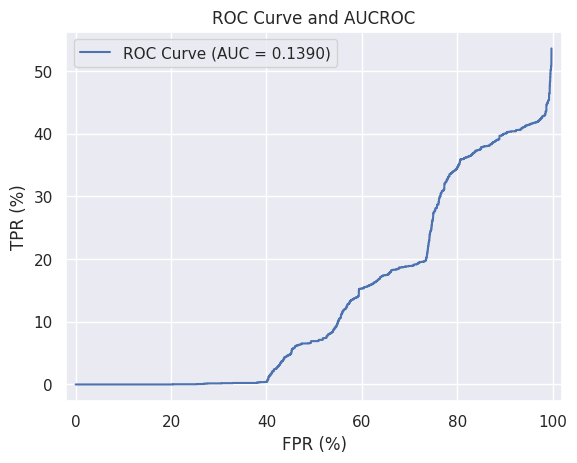

In [ ]:
plot_roc_curve(y_val_subset, val_scores_one_class)

Ao plotar a matriz de confusão, percebemos que houve diminuição no verdadeiros positivos. Houve aumento nos falsos negativos e verdadeiros negativos. Além disso, houve uma diminuição considerável nos falsos positivos, o que é interessante, pois é melhor que um modelo considere um dado benigno como maligno do que um dados maligno como benigno, tendo em vistas os prejuízos que isso geraria.

In [ ]:
val_predict_one_class = svm2.predict(norm_X_val_subset)

In [ ]:
val_predict_one_class[val_predict_one_class == 1] = 0
val_predict_one_class[val_predict_one_class == -1] = 1

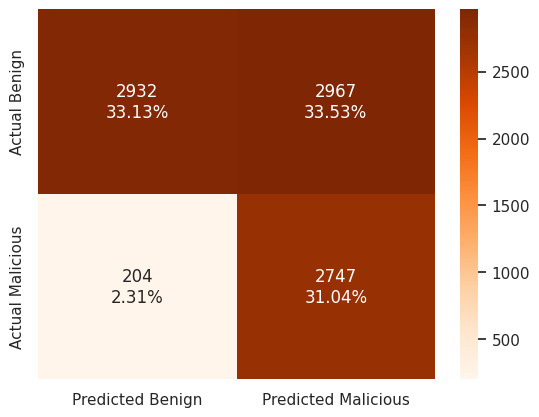

In [ ]:
plot_confusion_matrix(y_val_subset, val_predict_one_class)

Nas métricas gerais é perceptível que a acuracia, taxa de verdadeiro positivo, recall e taxa de falso positivo cairam, enquanto a precisão e f1-score melhoraram.

In [ ]:
get_overall_metrics(y_val_subset, val_predict_one_class)

{'acc': 0.6416949152542373,
 'tpr': 0.9308708912233141,
 'fpr': 0.5029666045092388,
 'precision': 0.4807490374518726,
 'recall': 0.9308708912233141,
 'f1-score': 0.6340450086555106}

Na célula seguinte, percebe-se uma boa taxa de verdadeiro positivos para todos tipos de ataque.

In [ ]:
get_tpr_per_attack(classes_val_subset, val_predict_one_class)

{'DoS Hulk': 0.9424398625429553,
 'DDoS': 0.9736842105263158,
 'PortScan': 0.8262987012987013,
 'DoS GoldenEye': 1.0,
 'FTP-Patator': 1.0,
 'DoS slowloris': 1.0,
 'DoS Slowhttptest': 1.0,
 'SSH-Patator': 0.9259259259259259,
 'Bot': 0.75,
 'Brute Force': 1.0,
 'XSS': 1.0}

Quanto a curva ROC, temos um AUC menor em relação ao modelo com parâmetros não tunados. Isso reflete em uma capacidade menor de distinguir uma padrão normal de um anômalo.

#Conjunto de testes#

usando parametros nao tunados

In [ ]:
test_score_one_class = svm.score_samples(norm_X_test_subset)

In [ ]:
test_score_one_class = np.abs(test_score_one_class)

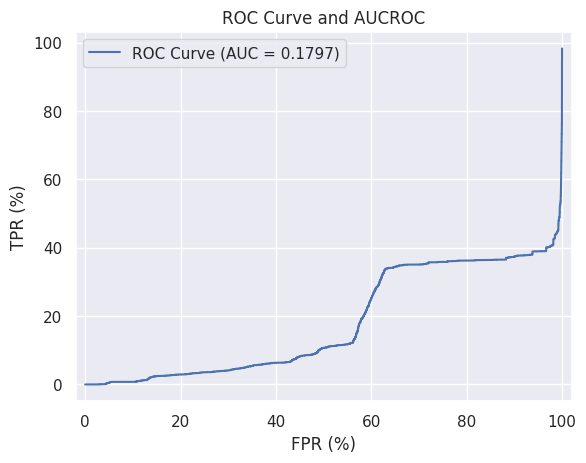

In [ ]:
plot_roc_curve(y_test_subset, test_score_one_class)

In [ ]:
test_predict_one_class = svm.predict(norm_X_test_subset)

In [ ]:
test_predict_one_class[test_predict_one_class == 1] = 0
test_predict_one_class[test_predict_one_class == -1] = 1

A matriz de confusão apresenta uma grande quantidade de verdadeiros positivos, uma quantidade razoável de falsos positivos e verdadeiros negativos e uma pequena quantidade de falsos negativos. Seria interessante reduzir esse número de falsos positivos.

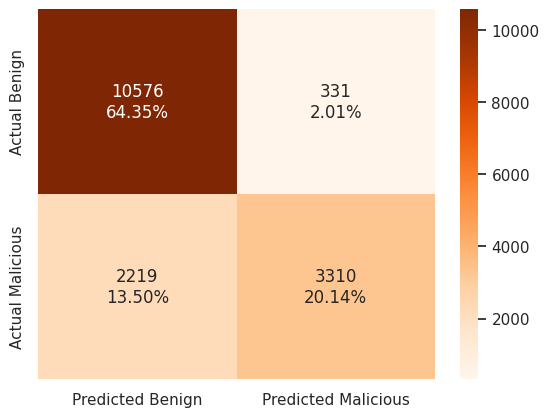

In [ ]:
plot_confusion_matrix(y_test_subset, test_predict_one_class)

In [ ]:
get_overall_metrics(y_test_subset, test_predict_one_class)

{'acc': 0.8448527622292529,
 'tpr': 0.5986616024597576,
 'fpr': 0.030347483267626294,
 'precision': 0.9090909090909091,
 'recall': 0.5986616024597576,
 'f1-score': 0.7219193020719737}

In [ ]:
get_tpr_per_attack(classes_test_subset, val_predict_one_class)

{'DoS Hulk': 0.6342905405405406,
 'DDoS': 0.6409036860879905,
 'PortScan': 0.6335403726708074,
 'DoS GoldenEye': 0.6842105263157895,
 'FTP-Patator': 0.6590909090909091,
 'SSH-Patator': 0.696969696969697,
 'DoS slowloris': 0.4666666666666667,
 'DoS Slowhttptest': 0.6923076923076923,
 'Bot': 0.5,
 'Brute Force': 0.35714285714285715,
 'XSS': 0.6666666666666666}

usando parametros nao tunados




In [ ]:
test_score_one_class = svm2.score_samples(norm_X_test_subset)

In [ ]:
test_score_one_class = np.abs(test_score_one_class)

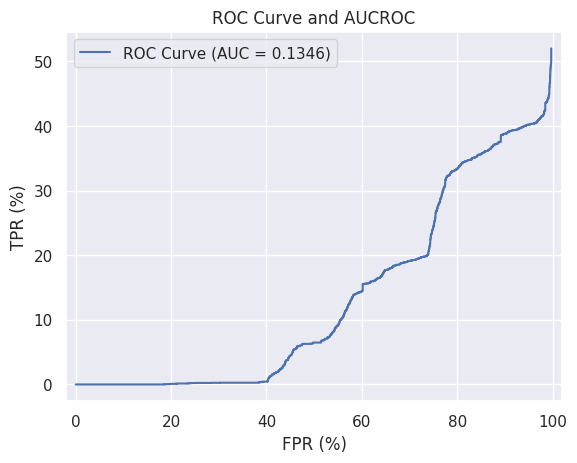

In [ ]:
plot_roc_curve(y_test_subset, test_score_one_class)

In [ ]:
test_predict_one_class = svm2.predict(norm_X_test_subset)

In [ ]:
test_predict_one_class[test_predict_one_class == 1] = 0
test_predict_one_class[test_predict_one_class == -1] = 1

Embora tenhamos tido um aumento considerável no número de falsos negativos, apresentamos um bom aumento no número de verdadeiros negativos e, principalmente, diminuimos o número de falsos positivos, o que será benéfico para o contexto de detecção de anômalias.

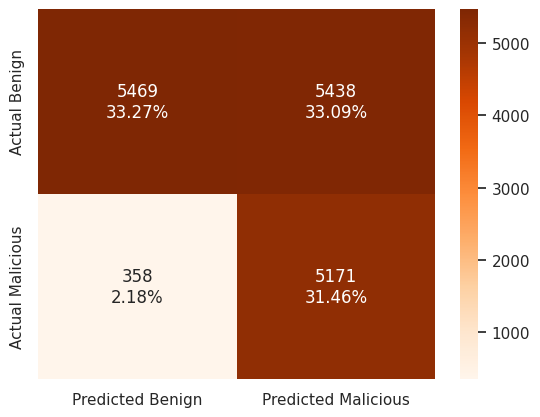

In [ ]:
plot_confusion_matrix(y_test_subset, test_predict_one_class)

Observamos uma redução na acuracia e precisão. Porém um aumento nas outras métricas.

In [ ]:
get_overall_metrics(y_test_subset, test_predict_one_class)

{'acc': 0.6473594548551959,
 'tpr': 0.9352504973774642,
 'fpr': 0.4985788942880719,
 'precision': 0.4874163446130644,
 'recall': 0.9352504973774642,
 'f1-score': 0.6408476886850911}

Não houve alteração na eficiência em relação aos tipos de ameaça

In [ ]:
get_tpr_per_attack(classes_test_subset, val_predict_one_class)

{'DoS Hulk': 0.6342905405405406,
 'DDoS': 0.6409036860879905,
 'PortScan': 0.6335403726708074,
 'DoS GoldenEye': 0.6842105263157895,
 'FTP-Patator': 0.6590909090909091,
 'SSH-Patator': 0.696969696969697,
 'DoS slowloris': 0.4666666666666667,
 'DoS Slowhttptest': 0.6923076923076923,
 'Bot': 0.5,
 'Brute Force': 0.35714285714285715,
 'XSS': 0.6666666666666666}

Quanto a curva ROC, percebemos que temos uma AUC menor em relação ao modelo não tunados. Isso reflete em uma menor capacidade de distinguir padrôes normal de anômalos.